## Importing libraries & Reading files

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import math
import matplotlib.pyplot as plt
import datetime
from datetime import date
from tqdm.notebook import tqdm

f_path = r"C:\Users\admin\Dropbox\Purnanand\PMS\Fundamental Analysis\Main Files\CSV\All Fundamental Data.csv"
c_path  = r"C:\Users\admin\Dropbox\Purnanand\PMS\Fundamental Analysis\Main Files\CSV\All Close Prices.csv"

fdf = pd.read_csv(f_path)
cdf = pd.read_csv(c_path)

fdf.drop(columns=['Unnamed: 0'],inplace=True)
cdf.drop(columns=['Unnamed: 0'],inplace=True)

# Input Variables
Enter your Input varibales here, in the given format

In [12]:
start_year = 2015           # Format : YYYY

buy_date   = '2021-07-01'   # Format : YYYY-MM-DD
sell_date  = '2022-07-01'   # Format : YYYY-MM-DD

indicator  = "ROCE"         # Format : "ROCE" or "ROE"
n = 30                      # To get Top n companies

transaction_cost = 0.1      # Percentage of Transaction cost eg.input 1 if you want 1% ; here 0.1 => 0.1%
capital = 1000000           # Capital in the beginning of the backtest


----

### Getting data from inputs
No output for this code, just some minor calculations.

In [13]:
compounded_capital = capital
initial_capital   = capital

buy_date = pd.to_datetime(buy_date)
sell_date = pd.to_datetime(sell_date)

buy_str  = f"-{buy_date.month}-{buy_date.day}"
sell_str = f"-{sell_date.month}-{sell_date.day}"

# Getting End Year date

if buy_date.month > 3:
    end_year = buy_date.year - 1
else :
    end_year = buy_date.year - 2
    
end_year

2020

----

## TRADE SHEET GENERATION CODE
Run this code to get the Trade Sheet

In [14]:
# Blank Dataframe to store Yearly Tradesheet
change = pd.DataFrame()

for year in tqdm(range(start_year, end_year+1)):
    
    f1 = fdf[fdf['Year']==year]
    
    # Fundamental Conditions
    conditions = ["Shareholder's Funds", "PAT", "PBIT"]
    
    for condition in conditions:
        f1 = f1[f1.fillna(0)[condition] > 0]
    
    # Market Cap Condition
    f1 = f1[f1['Market Cap']>=100]
    
    cdf['Date'] = pd.to_datetime(cdf['Date'])
    cdf['Year'] = cdf['Date'].dt.year
    
    # Indicator Conditions
    if indicator == "ROCE" :
        
        # Remove Banking stocks in ROCE
        f1 = f1[~f1['Name'].str.contains('Bank')]
        
        # ROCE Formula
        f1[indicator] = (f1['PBIT'].fillna(0) / (f1["Shareholder's Funds"].fillna(0) + f1["Long Term Borrowings"].fillna(0) + f1["Short Term Borrowings"].fillna(0)))*100

    elif indicator == "ROE" :
        
        # ROE Formula
        f1[indicator] = (f1['PAT'].fillna(0) / f1["Shareholder's Funds"].fillna(0))*100
        
        
    # New dataframe to store calculations 
    f2 = f1[['Name',indicator]]                                                            # Name, Indicator
    f2['Buy Date'] = date(year+1,buy_date.month,buy_date.day)                                                        # Buy Date
    
    # Dataframe of companies containing closings on 1st July of start year & next year
    cnam  = cdf[cdf['Date'] == f'{year+1}{buy_str}']
    cnam2 = cdf[cdf['Date'] == f'{year+2}{sell_str}']
    
    
    # Reset Indexes
    f2.reset_index(drop=True,inplace=True)
    cnam.reset_index(drop=True,inplace=True)
    
    
    # Adding Closing Prices of Start year (Buying Price) and dropping companies with no Closing prices 
    f2 = pd.merge(f2,cnam[['Name','Close']], how='left',on='Name').dropna()
    f2.rename(columns={'Close':'Close1'},inplace=True)
    f2 = f2.sort_values(by=['ROCE'], ascending=False)
    
    f2.reset_index(drop=True,inplace=True)                                                 # Reset Indexes
    
    # Adding Selling Date
    f2['Sell Date'] = date(year+2,sell_date.month,sell_date.day)
    
    # Adding Closing Prices of Next year (Selling Price) and dropping companies with no Closing prices 
    f2 = pd.merge(f2,cnam2[['Name','Close']], how='left',on='Name')
    f2.rename(columns={'Close':'Close2'},inplace=True)                                     # Reset Indexes
    
    # New Dataframe to store Top n Companies and Find Quantity
    f3 = f2[:30]
    
    # Filling companies with no Selling Prices with last present close and update the Selling Dates
    for i in range(f3.shape[0]):
        if f3.fillna(0)['Close2'].iloc[i] == 0 :
            f3['Close2'].iloc[i] = cdf[(cdf['Name']==f3['Name'].iloc[i]) & (cdf['Date'] < f'{year+2}{sell_str}')]['Close'].iloc[0]
            f3['Sell Date'].iloc[i] = cdf[(cdf['Name']==f3['Name'].iloc[i]) & (cdf['Date'] < f'{year+2}{sell_str}')]['Date'].iloc[0].date()
    
    # Claculating Quantity
    f3['Qty'] = capital/(n*f3['Close1'])
    
    # Defining a function for Roundown
    def Floor(x):
        try:
            return math.floor(x)
        except:
            return(x)
    
    # Rounddown Quantity
    f3['Qty'] = f3['Qty'].apply(Floor)
    
    # Buying & Selling Value = Qty x Close Price
    f3['Buy Value'] = f3['Qty']*f3['Close1']
    f3['Sell Value'] = f3['Qty']*f3['Close2']
    
    f3['% Change'] = (f3['Close2'] / f3['Close1'] - 1)*100
    
    f3['Transaction Cost'] = (transaction_cost / 100)*(f3['Buy Value']+f3['Sell Value'])
    
    #print(f"{year} Starting Capital is {capital}")
    
    capital = f3['Sell Value'].sum() - f3['Transaction Cost'].sum()
    
    #print(f"{year} Ending Capital is {capital}")
    
    change = change.append(f3)
    
display(change)    

  0%|          | 0/6 [00:00<?, ?it/s]

,Name,ROCE,Buy Date,Close1,Sell Date,Close2,Qty,Buy Value,Sell Value,% Change,Transaction Cost
0,Castrol India Ltd.,165.351540,2016-07-01,196.825,2017-07-01,202.35,169,33263.425,34197.15,2.807062,67.460575
1,Ashapura Minechem Ltd.,110.865100,2016-07-01,70.900,2017-07-01,56.30,470,33323.000,26461.00,-20.592384,59.784000
2,Fourth Dimension Solutions Ltd.,110.343427,2016-07-01,6.900,2017-07-01,13.56,4830,33327.000,65494.80,96.521739,98.821800
3,Accelya Solutions India Ltd.,93.178573,2016-07-01,1125.350,2017-07-01,1328.00,29,32635.150,38512.00,18.007731,71.147150
4,Chembond Chemicals Ltd.,90.539831,2016-07-01,224.125,2017-07-01,238.30,148,33170.500,35268.40,6.324596,68.438900
...,...,...,...,...,...,...,...,...,...,...,...
25,Ajanta Soya Ltd.,51.640576,2021-07-01,22.840,2022-07-01,51.55,2054,46913.360,105883.70,125.700525,152.797060
26,Accelya Solutions India Ltd.,51.432350,2021-07-01,1185.100,2022-07-01,878.90,39,46218.900,34277.10,-25.837482,80.496000
27,TAAL Enterprises Ltd.,51.384390,2021-07-01,639.650,2022-07-01,1525.55,73,46694.450,111365.15,138.497616,158.059600
28,Tata Consultancy Services Ltd.,51.365798,2021-07-01,3341.500,2022-07-01,3315.10,14,46781.000,46411.40,-0.790064,93.192400


----

## REPORTS GENERATION CODE
Run this code to get the Trade Reports


TOP WINNERS


,Name,Buy Date,% Change
0,Alkyl Amines Chemicals Ltd.,2020-07-01,327.409117
1,Ashapura Minechem Ltd.,2020-07-01,230.021598
2,Indiamart Intermesh Ltd.,2020-07-01,223.082839
3,Sonata Software Ltd.,2020-07-01,216.624738
4,NIIT Ltd.,2020-07-01,214.185165
5,Avanti Feeds Ltd.,2016-07-01,188.634829
6,Linde India Ltd.,2020-07-01,168.482948
7,Caplin Point Laboratories Ltd.,2016-07-01,157.632965
8,TAAL Enterprises Ltd.,2021-07-01,138.497616
9,New Delhi Television Ltd.,2021-07-01,131.633356



TOP LOSERS


,Name,Buy Date,% Change
0,Fourth Dimension Solutions Ltd.,2018-07-01,-87.692308
1,Suumaya Industries Ltd.,2021-07-01,-78.824268
2,Viaan Industries Ltd.,2018-07-01,-69.611111
3,Paul Merchants Ltd.,2018-07-01,-65.376787
4,Websol Energy System Ltd.,2017-07-01,-60.361842
5,KSE Ltd.,2018-07-01,-58.780161
6,Adroit Infotech Ltd.,2017-07-01,-58.476658
7,Bhansali Engineering Polymers Ltd.,2018-07-01,-58.158996
8,Kushal Ltd.,2017-07-01,-57.963070
9,Primo Chemicals Ltd.,2019-07-01,-56.767956


  0%|          | 0/6 [00:00<?, ?it/s]


Daily Portfolio Value


,Date,PV
0,2022-06-30 00:00:00,1460086.98
1,2022-06-29 00:00:00,1462936.41
2,2022-06-28 00:00:00,1461972.41
3,2022-06-27 00:00:00,1463923.655
4,2022-06-26 00:00:00,1449659.33
...,...,...
360,2016-07-05 00:00:00,990531.914265
361,2016-07-04 00:00:00,992610.042175
362,2016-07-03 00:00:00,986418.820493
363,2016-07-02 00:00:00,986418.820493


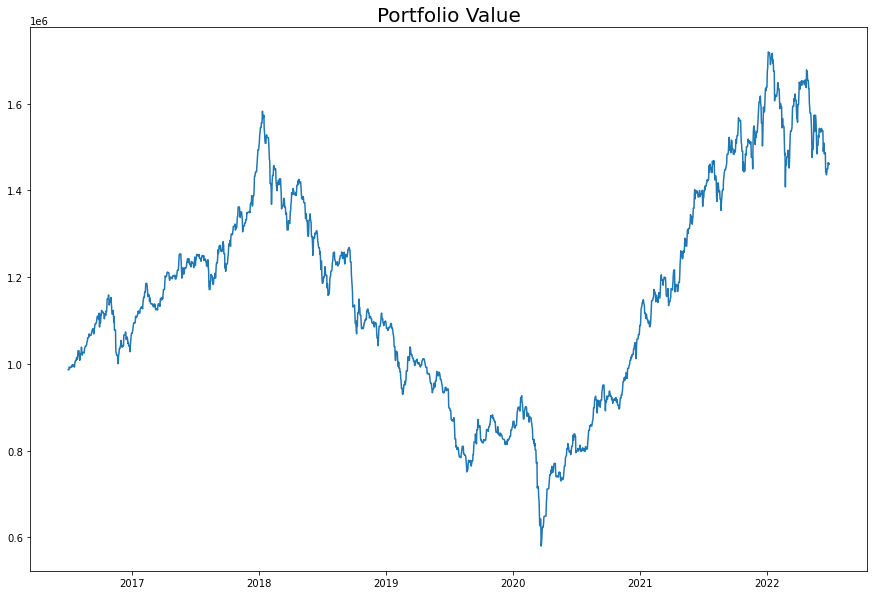

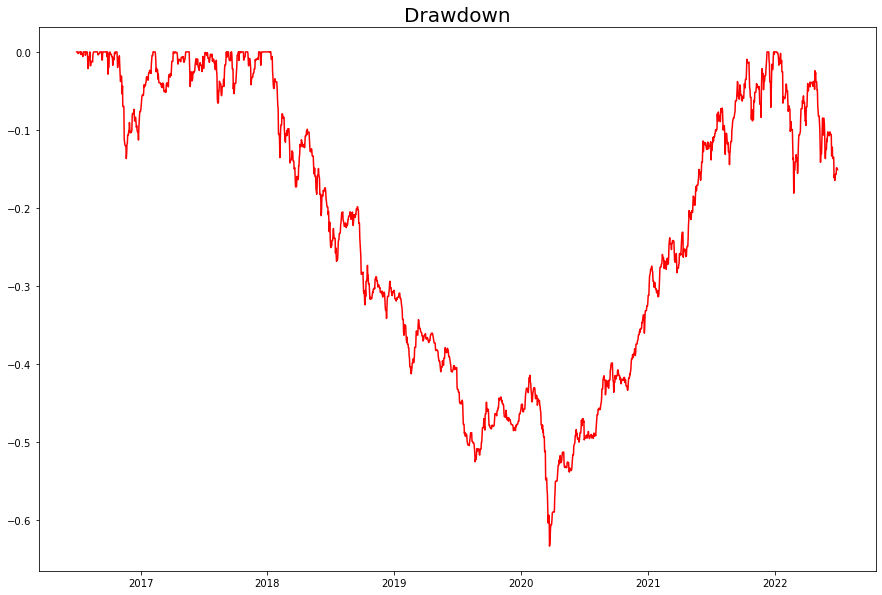

,CAGR,Trading Edge,MDD,CAR/MDD
0,6.400424,13.54782,-63.386203,0.100975


In [15]:
#display(change)

# TOP n Winners & Losers

winners = change.sort_values(by="% Change", ascending=False)[['Name','Buy Date','% Change']]
losers = change.sort_values(by="% Change", ascending=True)[['Name','Buy Date','% Change']]
winners.reset_index(drop=True, inplace=True)
losers.reset_index(drop=True, inplace=True)


winners_counts = change[change['% Change']>0].shape[0] / change.shape[0]
losers_counts  = change[change['% Change']<0].shape[0] / change.shape[0]

avg_win  = change[change['% Change']>0]['% Change'].mean()
avg_loss = change[change['% Change']<0]['% Change'].mean()


print("\nTOP WINNERS")
display(winners[:10])

print("\nTOP LOSERS")
display(losers[:10])




# Finding Daily Portfolio Value

k = 0

combined_PV = pd.DataFrame(columns=['Date','PV'])

for year in tqdm(range(start_year,end_year+1)):
    
    #print(year)
    multipv = pd.DataFrame(columns=['Date','PV'])
    multipv['Date'] = pd.date_range(date(year+1,buy_date.month,buy_date.day) ,date(year+2,sell_date.month,sell_date.day)-datetime.timedelta(1)).sort_values(ascending=False)
    multipv['PV'].fillna(0,inplace=True)
    
    for i in range(k,n+k):

        pv1 = cdf[(cdf['Name']==change['Name'].iloc[i]) & (cdf['Date'] >= f'{year+1}{buy_str}') & (cdf['Date'] < f'{year+2}{sell_str}')]

        pv1 = pv1[['Name','Date','Close']]
        pv1.reset_index(drop=True, inplace = True)

        all_dates = pd.DataFrame(columns=['Name','Date','Close'])
        all_dates['Date'] = pd.date_range(date(year+1,buy_date.month,buy_date.day) ,date(year+2,sell_date.month,sell_date.day)-datetime.timedelta(1)).sort_values(ascending=False)
        
        
        
        for j in range(all_dates.shape[0]):
            if all_dates['Date'].iloc[j] not in pv1['Date'].tolist():
                pv1 = pv1.append(all_dates.iloc[j])
        
        
        pv1.sort_values(by='Date', ascending=False, inplace=True) 
        pv1.reset_index(drop=True, inplace = True)
        
        pv1 = pv1[['Name','Date','Close']].bfill().ffill()
        pv1.reset_index(drop=True, inplace = True)
        
        pv1['PV'] = pv1['Close']*change['Qty'].iloc[i]
        pv1['Date'] = pd.to_datetime(pv1['Date'])
        
#         display(pv1)
#         display(multipv)
        
        multipv['PV'] = np.where(multipv['Date'] == pv1['Date'], multipv['PV']+pv1['PV'], np.nan)

    combined_PV = multipv.append(combined_PV)
    k += n

print("\nDaily Portfolio Value")
display(combined_PV)

print()



combined_PV = combined_PV.sort_values(by='Date', ascending=True)
combined_PV['MDD'] = (combined_PV['PV']/combined_PV['PV'].rolling(len(combined_PV),1).max())-1
combined_PV = combined_PV.sort_values(by='Date',ascending=False)
combined_PV.reset_index(drop=True,inplace=True)



plt.figure(figsize=(15,10))
plt.plot(combined_PV["Date"],combined_PV["PV"])
plt.title("Portfolio Value", fontsize=20)
plt.show()

plt.figure(figsize=(15,10))
plt.plot(combined_PV["Date"],combined_PV["MDD"],color = 'red')
plt.title("Drawdown", fontsize=20)
plt.show()


# Ratios

tradingedge = winners_counts*avg_win + losers_counts*avg_loss

cagr        = ((capital/initial_capital)**(1/(end_year-start_year+1))-1)*100

mdd         = min(combined_PV['MDD'])*100

calc = pd.DataFrame({"CAGR":[cagr],  "Trading Edge":[tradingedge], "MDD":[mdd], "CAR/MDD":[-cagr/mdd]})

display(calc)

___________

## Output Variable names
* change : Tradelist
* combined_PV : Daily Portfolio Value
* winners : All Winners in descending
* losers : All Losers in ascending
* cagr : CAGR
* tradingedge : Trading Edge
* mdd : Max Drawdown

___________